# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql import functions as sF
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Basic Data structure Checks

In [4]:
# Total Number of observations
df.count()

286500

In [5]:
#Checking for missing user id in Spark
df.filter(df.userId == '').count()

8346

In [6]:
# Dropping the missing User's ID rows
df = df.filter(df.userId != '')

In [7]:
df.filter(df.userId == '').count()

0

In [8]:
# Removing duplicate UserID
df.select("userId").dropDuplicates().count()

225

In [9]:
# Removing duplicates in Session ID
df.select("sessionId").dropDuplicates().count()

2312

In [10]:
# Number of observations left
df.count()

278154

In [11]:
# Checking the structure of some features
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [12]:
# Let's check users who did "Cancellation Confirmation"
df.select("artist").distinct().show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



# Exploratory Data Analysis

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [13]:
# Clean the NA value in userId and sessionId
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

278154

In [14]:
# Transforming date and time features of dataset

get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In [15]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%H"))
df = df.withColumn("hour", get_hour(df.ts))

In [16]:
# Analyzing one single user with "Cancellation Confirmation"
df.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId == "125").sort("time").show(100)

+------+--------------------+-------------------+-----+--------------------+---------+
|userId|                page|               time|level|                song|sessionId|
+------+--------------------+-------------------+-----+--------------------+---------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|      174|
|   125|            NextSong|2018-10-12 04:32:08| free|     They're Red Hot|      174|
|   125|            NextSong|2018-10-12 04:35:06| free|                Kota|      174|
|   125|         Roll Advert|2018-10-12 04:

In [17]:
# Extracting Location information from data
get_location=udf(lambda x:x[-2:])
df = df.withColumn("location_state", get_location(df.location))

In [18]:
df.select("location_state").distinct().show()

+--------------+
|location_state|
+--------------+
|            AZ|
|            SC|
|            LA|
|            NJ|
|            OR|
|            VA|
|            KY|
|            NH|
|            MI|
|            NV|
|            WI|
|            ID|
|            CA|
|            CT|
|            MT|
|            NC|
|            MD|
|            MO|
|            IL|
|            WA|
+--------------+
only showing top 20 rows



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [19]:
# Churn is a label for user who cancelled

# Define a flag function
churn_users = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# apply to the dataframe
df = df.withColumn("churn", churn_users("page"))

#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Applying the window
df_withchurn = df.withColumn("churn", Fsum("churn").over(windowval))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
#Drop duplicates in userId in spark
df_withchurn.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [21]:
#Drop duplicates user status by gender in Spark
df_withchurn.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



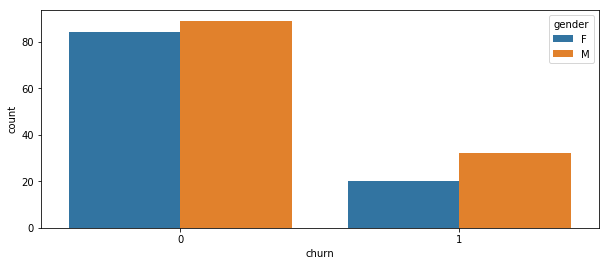

In [22]:
#Plotting Gender wise churn statistics in a graph

plt.figure(figsize=(10, 4))
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd);

In [23]:
# Customer lifetime statistics
lifetime_pd = df_withchurn.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
lifetime_pd = lifetime_pd.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

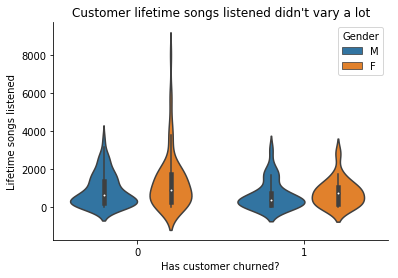

In [24]:
ax = sns.violinplot(data=lifetime_pd, x='churn', y='NextSong', hue='gender')
plt.xlabel('Has customer churned?')
plt.ylabel('Lifetime songs listened')
plt.legend(title='Gender', loc='best')
plt.title('Customer lifetime songs listened didn\'t vary a lot')
sns.despine(ax=ax);

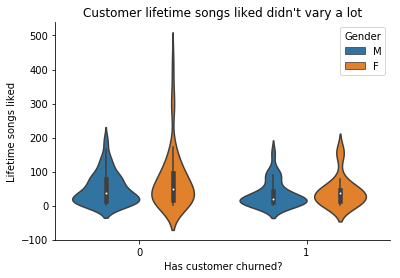

In [25]:
ax = sns.violinplot(data=lifetime_pd, x='churn', y='Thumbs Up', hue='gender')
plt.xlabel('Has customer churned?')
plt.ylabel('Lifetime songs liked')
plt.legend(title='Gender', loc='best')
plt.title('Customer lifetime songs liked didn\'t vary a lot')
sns.despine(ax=ax);

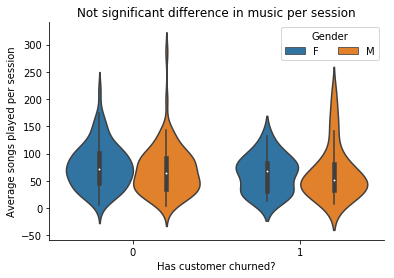

In [27]:
# Number of songs played per session 

songs_gender_pd = df_withchurn.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songs_gender_pd)
plt.xlabel('Has customer churned?')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
plt.title('Not significant difference in music per session')
sns.despine(ax=ax);

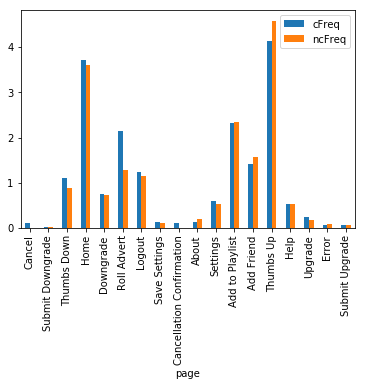

In [27]:
# Showing the page wise distribution between churn user and normal user

churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

plt.figure(figsize=(14, 6))
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page");

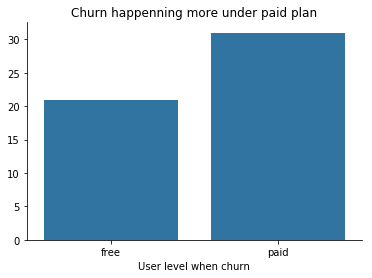

In [28]:
# Churn stats by User level

level_pd = df_withchurn.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()

ax = sns.barplot(data=level_pd, x='level', y='count', color=sns.color_palette()[0])
plt.xlabel('User level when churn')
plt.ylabel('')
plt.title('Churn happenning more under paid plan')
sns.despine(ax=ax);

In [29]:
# Checking if there is any relation between chrun customers with time

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_withchurn = df_withchurn.withColumn("hour", get_hour(df_withchurn.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_withchurn = df_withchurn.withColumn("weekday", get_weekday(df_withchurn.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_withchurn = df_withchurn.withColumn("day", get_day(df_withchurn.ts))

In [30]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = df_withchurn.filter(df_withchurn.page == "NextSong").groupby("churn", time).count().orderBy(df_withchurn[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn==0].plot.bar(x=time, y='count', color='Orange', label='Not churn')
    df_pd[df_pd.churn==1].plot.bar(x=time, y='count', color='Grey', label='Churn')

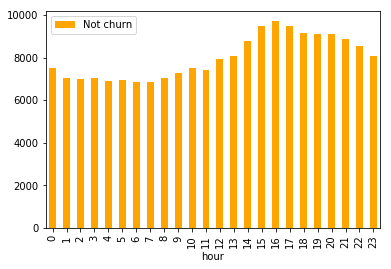

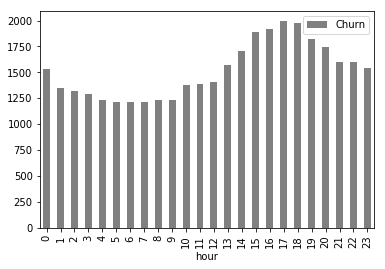

In [31]:
plot_cnt_by_churn("hour")

**Not a definite relationship identified but we can see that evening time has shown more user interaction in both the population type.**

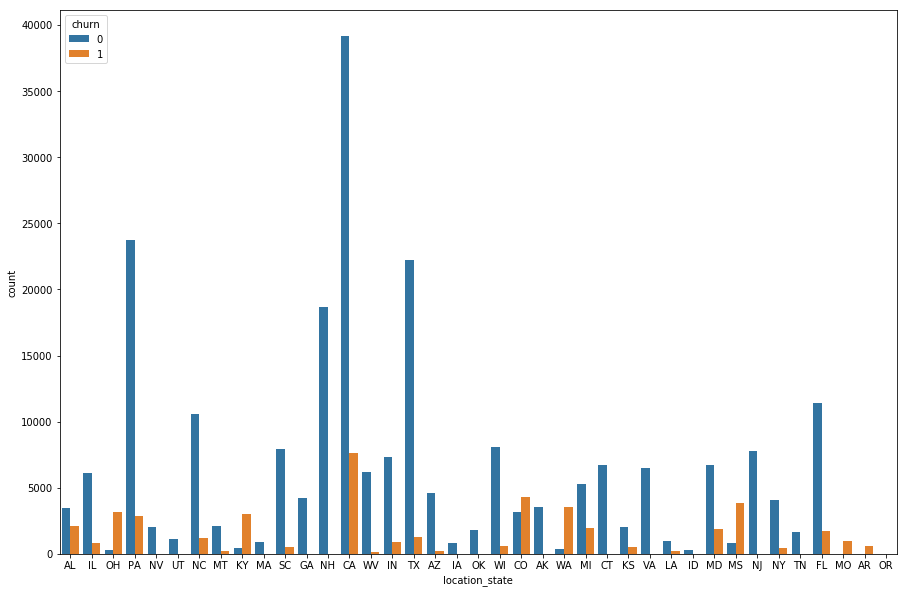

In [32]:
# Churn pattern based on location of the users
plt.figure(figsize=(15,10))
df_location=df_withchurn.groupby(["location_state", "churn"]).count().sort("churn").toPandas()
sns.barplot(x='location_state', y='count', hue='churn', data=df_location);

- Clifornia state has most numbers of Non Churn users present followed by Pennsylvania, Texas & New Hampshire. - Further although churn ratio is also higher for CA when compared to other ones but if we see state wise distribution b/w both user types, it is not in similar ration & differs location wise. 
- Some states has less churned users compared to others.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [33]:
# Create a dataframe for churn users

churn_users = df_withchurn.select('userId', 'churn').dropDuplicates()

# check
churn_users.show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [34]:
# Feature 1: number of days since registration
user_max_ts = df_withchurn.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



In [35]:
# Feature 2: Total songs per user
song_per_user = df_withchurn\
                  .select("userId","song")\
                  .groupby("userId")\
                  .count()\
                  .withColumnRenamed("count","song_per_user")
song_per_user.show(10)

+------+-------------+
|userId|song_per_user|
+------+-------------+
|100010|          381|
|200002|          474|
|   125|           11|
|    51|         2464|
|   124|         4825|
|     7|          201|
|    54|         3437|
|    15|         2278|
|   155|         1002|
|   132|         2304|
+------+-------------+
only showing top 10 rows



In [36]:
# Feature 3: Gender wise distribution

gender = df_withchurn\
         .select('userId','gender')\
         .replace(['M','F'],['0','1'],'gender')\
         .select('userId',col('gender').cast('int'))\
         #.withColumnRenamed('gender', 'gender_num') 
gender.show(20)

+------+------+
|userId|gender|
+------+------+
|    30|     0|
|     9|     0|
|    30|     0|
|     9|     0|
|    30|     0|
|     9|     0|
|     9|     0|
|    30|     0|
|    30|     0|
|    30|     0|
|     9|     0|
|     9|     0|
|    30|     0|
|     9|     0|
|     9|     0|
|    30|     0|
|     9|     0|
|    74|     1|
|    30|     0|
|     9|     0|
+------+------+
only showing top 20 rows



In [37]:
# Feature 4: Listening Time per user

listening_time = df_withchurn\
            .select('userId','length')\
            .groupby(['userId'])\
            .sum()\
            .withColumnRenamed('sum(length)','listening_time')

listening_time.show(10)

+------+------------------+
|userId|    listening_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
+------+------------------+
only showing top 10 rows



In [38]:
#Feature 5: avg & min & max time per session
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")
user_session_time_stat.show(5)

+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
|100003| 99.11666666666667|3.216666666666667|195.01666666666668|
+------+------------------+-----------------+------------------+
only showing top 5 rows



In [39]:
# Feature 6: number of sessions
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")
user_session_count.show(5)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



In [40]:
# Feature 7: Number of songs per session

user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")
user_session_songs_avg.show(5)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
+------+------------------+
only showing top 5 rows



In [41]:
# Feature 8:session duration

session_end = df_withchurn.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'end')
session_start = df_withchurn.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(3)

+------+---------+------------------+
|userId|sessionId|     session_hours|
+------+---------+------------------+
|   101|      635|55.000277777777775|
|   110|     1776|1.3908333333333334|
|   120|      627|15.855555555555556|
+------+---------+------------------+
only showing top 3 rows



In [42]:
# mean and standard dev. of session duration

session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0

session_user_df = session_user_df.na.fill(0)
session_user_df.show(3)

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
+------+-------------------+------------------+
only showing top 3 rows



In [43]:
# Feature 9: Type of user (Paid:1 or Free:0)

user_paid = df_withchurn.groupby("userId", "level").agg(max(df_withchurn.ts).alias("finalTime")).sort("userId")
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))
user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))
user_recent_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



In [44]:
# Feature 10: how many artists have the user heard

user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")
user_artist_count.show(5)

+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



In [45]:
# All the features to collect

features_list = [user_reg_days, song_per_user, gender, 
                   listening_time, user_session_time_stat, user_session_count, session_user_df, 
                   user_session_songs_avg, user_recent_level, user_artist_count]
features_list_names = ['user_reg_days', 'song_per_user', 'gender', 
                   'listening_time', 'user_session_time_stat', 'user_session_count', 'session_user_df',
                   'user_session_songs_avg', 'user_recent_level', 'user_artist_count']

In [46]:
# Initialize the final_df

df_final = churn_users

def join_features(base, new):
    df_to_join = new 
    base = base.join(df_to_join, 'userId', how='inner')
    return base.dropDuplicates()

for i, feature in enumerate(features_list):
    print(f'Preparing features of the {features_list_names[i]} dataframe', end='; ')
    df_final = join_features(df_final, feature)
    print (f"the new frame's dimensions is: {df_final.count()} * {len(df_final.columns)}")
df_final1 = df_final.orderBy('userId', ascending=True)

Preparing features of the user_reg_days dataframe; the new frame's dimensions is: 225 * 3
Preparing features of the song_per_user dataframe; the new frame's dimensions is: 225 * 4
Preparing features of the gender dataframe; the new frame's dimensions is: 225 * 5
Preparing features of the listening_time dataframe; the new frame's dimensions is: 225 * 6
Preparing features of the user_session_time_stat dataframe; the new frame's dimensions is: 225 * 9
Preparing features of the user_session_count dataframe; the new frame's dimensions is: 225 * 10
Preparing features of the session_user_df dataframe; the new frame's dimensions is: 225 * 12
Preparing features of the user_session_songs_avg dataframe; the new frame's dimensions is: 225 * 13
Preparing features of the user_recent_level dataframe; the new frame's dimensions is: 225 * 14
Preparing features of the user_artist_count dataframe; the new frame's dimensions is: 225 * 15


In [47]:
df_final1.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- regDay: double (nullable = true)
 |-- song_per_user: long (nullable = false)
 |-- gender: integer (nullable = true)
 |-- listening_time: double (nullable = true)
 |-- avgSessionTime: double (nullable = true)
 |-- minSessionTime: double (nullable = true)
 |-- maxSessionTime: double (nullable = true)
 |-- sessionCount: long (nullable = false)
 |-- mean_session_h: double (nullable = false)
 |-- stdev_session_h: double (nullable = false)
 |-- avgSessionSongs: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- aritstCount: long (nullable = false)



In [48]:
# Change the column names to strings without spaces
for col in df_final1.columns:
    df_final1 = df_final1.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
print(df_final1.columns)

['userId', 'churn', 'regDay', 'song_per_user', 'gender', 'listening_time', 'avgSessionTime', 'minSessionTime', 'maxSessionTime', 'sessionCount', 'mean_session_h', 'stdev_session_h', 'avgSessionSongs', 'level', 'aritstCount']


In [49]:
from pyspark.sql import types as sT

# Convert all to numbers as the schema shows strings

# the first column (userId) would be integer
df_final1 = df_final1.withColumn('userId', df_final1.userId.cast(sT.IntegerType()))

# All columns from Churn to OS_* should be integer types
for col in df_final1.columns[1:12]:
    df_final1 = df_final1.withColumn(col, df_final1[col].cast(sT.IntegerType()))

# All other columns should be float
for col in df_final1.columns[12:]:
    df_final1 = df_final1.withColumn(col, df_final1[col].cast(sT.FloatType()))

df_final1.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- regDay: integer (nullable = true)
 |-- song_per_user: integer (nullable = false)
 |-- gender: integer (nullable = true)
 |-- listening_time: integer (nullable = true)
 |-- avgSessionTime: integer (nullable = true)
 |-- minSessionTime: integer (nullable = true)
 |-- maxSessionTime: integer (nullable = true)
 |-- sessionCount: integer (nullable = false)
 |-- mean_session_h: integer (nullable = true)
 |-- stdev_session_h: integer (nullable = true)
 |-- avgSessionSongs: float (nullable = true)
 |-- level: float (nullable = true)
 |-- aritstCount: float (nullable = false)



In [50]:
# Removing nulls from anywhere replacing them by zeros

df_final1 = df_final1.na.fill(0)

In [51]:
# sort and view the final dataframe
df_final1 = df_final1.sort("userId")
df_final1.show(5)

+------+-----+------+-------------+------+--------------+--------------+--------------+--------------+------------+--------------+---------------+---------------+-----+-----------+
|userId|churn|regDay|song_per_user|gender|listening_time|avgSessionTime|minSessionTime|maxSessionTime|sessionCount|mean_session_h|stdev_session_h|avgSessionSongs|level|aritstCount|
+------+-----+------+-------------+------+--------------+--------------+--------------+--------------+------------+--------------+---------------+---------------+-----+-----------+
|     2|    0|    69|          899|     1|        188687|           445|            14|          1506|           7|             7|              8|      107.85714|  1.0|      587.0|
|     3|    1|    80|          254|     0|         54424|           247|            87|           546|           4|             4|              3|           53.5|  1.0|      197.0|
|     4|    0|    62|         2442|     0|        506140|           379|             3|        

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

**Pre-modeling steps**

In [52]:
#Checking number of records based on churn variable.
df_final1.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [53]:
# Putting features to be trained into vector by selecting only few columns to reduce overall model run time.

cols = ["regDay", "song_per_user", "gender", "sessionCount", "level", "aritstCount"]
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(df_final1)

**In order to avoid one feature with larger scale dominant the whole model, we standardize the features by taking off the mean and divided by the standard deviation of each feature.**

In [54]:
# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [55]:
# Select the output and input features
data = data.select(data.churn.alias("label"), data.ScaledNumFeatures.alias("features"))

In [56]:
# train test split
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)
train.count(), test.count(), validation.count()

(139, 79, 7)

**Baseline Model**

Here, I'll evaluate two baseline models, one with all users labelled as churn = 1, one with all users labelled as churn = 0. Then I'll calculate the model accuracy and f1 score.

In [57]:
results_base_all_1 = test.withColumn('prediction', lit(1.0))

In [58]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.26582278481012656
F-1 Score:0.11164556962025314


In [59]:
results_base_all_0 = test.withColumn('prediction', lit(0.0))

In [60]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.7341772151898734
F-1 Score:0.6216391019125936


**Further Steps:**

1. As we can see, the baseline model of labelling all users with churn = 0 does good on test set, with accuracy of 0.734 and f1 score of 0.621

2. Now, below I'll evaluate three different models. Then, I'll use cross validation to minimize the chance of overfitting and finally I'll use grid search to tune the model. 

3. After evaluating three models on validation set, I'll pick up the best one based on the f1 score on that and train the best model on training set again then to evaluate on test set.

In [61]:
# First Model: Logistic Regression

# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [62]:
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

[0.7195864510933004]

In [63]:
results_lr = cvModel_lr.transform(validation)

In [64]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.7142857142857143
F-1 Score:0.5952380952380951


In [65]:
#Second Model: Gradient Boosted Trees

# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [66]:
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.7079962714166309]

In [67]:
results_gbt = cvModel_gbt.transform(validation)

In [68]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.8571428571428571
F-1 Score:0.8398268398268397


In [69]:
#Third Model: Support Vector Machine 

# initialize classifier
svm = LinearSVC(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [70]:
cvModel_svm = crossval_svm.fit(train)
cvModel_svm.avgMetrics

[0.7000229931044872]

In [71]:
results_svm = cvModel_svm.transform(validation)

In [72]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('SVM Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.7142857142857143
F-1 Score:0.5952380952380951


**Model summary:**

Below is a quick snapshot of models performance on training data set.

**Logistic Regression Metrics:**

Accuracy: 0.7142857142857143
F-1 Score:0.5952380952380951

**Gradient Boosted Trees Metrics:**

Accuracy: 0.8571428571428571
F-1 Score:0.8398268398268397

**SVM Metrics:**

Accuracy: 0.7142857142857143
F-1 Score:0.5952380952380951

Although we do care about time resources, but since the data size is reletively small, and the performance difference also varies, I'll will prefer the model that perform the best amongs all 3. Therefore, GBT model will be my final used model as it has achieved best Accuracy & F1 scores from the other two models.

Next, I'll will use Grid-Search and Cross-validation techniques to fine tune hyper parameters so that I can further improve the performance of my model.

In [73]:
# Hyperparams tunning

GBTClassifier(maxIter=10,seed=42)

# build paramGrid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .addGrid(gbt.maxIter, [10,15]) \
    .build()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [74]:
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.7079962714166309, 0.6999102833306429, 0.717498809451873, 0.717498809451873]

In [75]:
gbt_best = GBTClassifier(maxIter=10,seed=42, maxDepth=5)
gbt_best_model = gbt_best.fit(train)
results_final = gbt_best_model.transform(test)

In [77]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.6962025316455697
F-1 Score:0.6496835443037974


**Result:**

- From the Grid-Search method,I've obtained an accuracy of 0.696 and F-1 Score of 0.649, which is lower than previous models but acceptable. This also make sense as testing dataset has further less data than training. 

- This will also improve once it will be tested on the full dataset. Here, I'm not willing to run this exercise on whole of the dataset becacuse that will take much time to process. 

- This small modeling exercise has took large amount of time for training all the 3 models above then tuning it.

- Now, it's important to identify the important variables which helps in determining the churn.

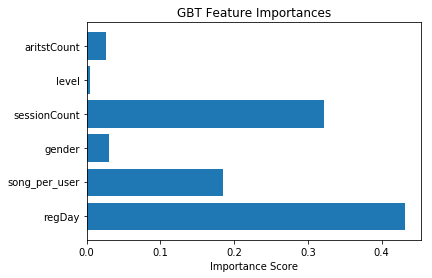

In [84]:
feat_imp = gbt_best_model.featureImportances.values
cols = ["regDay", "song_per_user", "gender", "sessionCount", "level", "aritstCount"]
y_pos = np.arange(len(cols))
 
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');

**Findings:**

- I've utilized the feature importance attribute of the Gradient Boosted Tree model. From the chart, we can see length of using the service i.e. RegDay actually plays a very important role. 

- But this may be biased as well with the fact that those who have churned had possibly used service for shorter period of time, and thus, we may re-consider our model or do some transformation to reduce the bias. 

- Other than that, session count & song per user also plays important role. I personally feel that song per user is directly related with the lenght of using service hence it also came as other important factor. Further, again if user has used service for long time, then it also make sense that he has take more sessions than other churned users.

**Conclusion:**

1. In this notebook, I've implemented a model trying to predict customers who will be churned in near future based on various factors available in given dataset. 

2. As part of data cleaning, I've removed rows where no userId was present, converted timestamp to a human readable format, converted gender to binary numeric column. 

3. In total 10 features were built for modeling purpose but given the fact that my model was taking much time to process, I've selected some key features to process in model. 

4. I've used 4 modeling techniques: logistic regression, GBM & SVM and selected GBM as the final model implemented for predicting final result. 

5. I've used cross validation and grid search methods to fine tune my model. here, I've achieved about 70% of accuracy, and F1 score of 0.65 , which is about 3% improvement compare to my baseline model for sending everyone an offer.

**Reflection:**

- This project gives me an exposure to spark environment that how we can analyze a large volume of data on a personal laptop which may not be capable enough to analyze. 

- It happened in my case where this smaller data also has take large amount of processing time, hence I've skipped my thought to rerun the process on the full data.

- By identifying customer with high chance of getting churned prior to the acutal losing, companies can use this information & wil be equipped better to retain them at minimal cost by using targeted messages and offers only to that pool of customers.

- One of the interesting yet difficult thing during the project was brainstroming the features that will be useful for actual modeling exercise. Developing useful features is crucial for developing a good model, and requires a lot of energy and efforts. Explanatory and exploratory data analysis play important role in this process.

**Improvement:**

- These features surely has enough room for improvement after considering more factors into analysis, adding more domain knowledges and expertise. Considering the fact that our model's data inputs for training, testing & validating has very less data (139, 79, 7) respectively, it has a huge potential to improve if the sample size increases, and the expected performance will also increase.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.